In [1]:
#Calling neccessary packages 
from math import *
from numpy import *
from pandas import *
from qiskit import *
import qiskit.quantum_info
import qiskit.visualization
from qiskit_aer import AerSimulator
from qiskit.circuit import SwitchCaseOp
from qiskit.visualization import *
from qiskit.result import marginal_counts
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
import mapomatic as mm
#service = QiskitRuntimeService(channel="ibm_quantum")
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="4aa3e6491eafc0c9915717ef7dd214e50c3cd61dc74cb27f3edb2941e70e5262c9855be3567ef414eee7d0be34fb189e39a9fce92a59e7dc3c78717a40ec1c69", overwrite=True)
#provider = IBMProvider()

In [2]:
from qiskit_aer import AerSimulator
import pandas as pd
import numpy as np
backend = AerSimulator()

In [3]:
#proiding the packages neccessary for desinging the Unitary gate needed to charge the battery and correlate the battery with the ancilla
from qutip import *
from qutip.qip.operations import *
from math import *
import pandas as pd
from numpy import *


c:\Users\Navid Elyasi\AppData\Local\Programs\Python\Python310\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [4]:


def get_values_from_csv(file_path, row_number):
    try:
        # Read the csv file into a DataFrame, specifying that the first column may contain complex numbers
        df = pd.read_csv(file_path, header=None)

        # Check if the specified row_number is valid
        if 0 <= row_number < df.shape[0]:
            # Get the values of the specified row
            row_values = df.iloc[row_number, :].tolist()
            return row_values
        else:
            print("Invalid row number. Please enter a valid row number.")
            return None

    except FileNotFoundError:
        print(f"File not found at the path: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None



In [5]:
#Adressing directory of the csv file
csv_file_path = "output-m.csv"



In [6]:
#Charging Operator
# Initially we have to define the Hamiltonian 
omega = 1
kappa = 1

H = omega * (tensor(sigmax(), qeye(2))) + kappa * (
tensor(sigmam(), sigmap()) + tensor(sigmap(), sigmam()))
# Generating the Unitary gate which is responsible for charging the battey and correlating it with the ancilla 
M_Unitary = (-1j * H).expm()
M_gate = UnitaryGate(M_Unitary)

In [7]:
#This section is for finding the Optimal Uniatry gate 
def find_unitary(Theta, Phi):
    U = None
    U = [[ cos(Theta) , -exp(-1j*Phi)*sin(Theta)], [exp(1j*Phi)*sin(Theta), cos(Theta)]]
    Unitary = UnitaryGate(U)
    return Unitary

In [8]:
#This block is for testing the syntax of writing built up two qubits gate using .unitary method. In fact when I write [q1, q0], it will act in the reversed form of the Qutip`s configuration of Hilbert Space. 
#In Qutip the mentioned combination will be written as $q0 \otimes q1$
omega = 1
kappa = 1

H = omega * (tensor(sigmax(), qeye(2)))
# Generating the Unitary gate which is responsible for charging the battey and correlating it with the ancilla 
test_gate = UnitaryGate(H)

q0 = QuantumRegister(1, name = 'battery')
q1 = QuantumRegister(1, name = 'ancilla')
creg  = ClassicalRegister(1)
qc = QuantumCircuit(q0, q1, creg)

qc.append(test_gate, [q1, q0]) # I meant here. $q0 \otimes q1$

qc.measure(q0, creg )
trans_qc = transpile(qc, backend=backend)
job = backend.run(trans_qc , shots = 10000)
results = job.result()
print(results.get_counts())

{'1': 10000}


In [9]:
#Initial Values 
Steps =1


#Circuit setup
q0 = QuantumRegister(1, name = 'battery')
q1 = QuantumRegister(1, name = 'ancilla')
creg  = ClassicalRegister(Steps+1)
qc = QuantumCircuit(q0, q1, creg)

#Creat an empty list to save the measurement results 
result_  = []

#Start the collisional model for arbitrary number of steps 
for i in range(Steps):
    qc.append(M_gate, [q1, q0])
    qc.h(q1)
    qc.measure(q1, creg[i])
    qc.barrier()
    qc.reset(q1)
    #qc.x(q1)
    #qc.barrier()


with qc.switch(creg) as case: 
    for i in range(2**Steps):
        with case(i): #the prevous code and search for the decimal code to find the corresponding Theta and Phii
            #Calling the Excel file created in
            Values = get_values_from_csv(csv_file_path, i)
            Theta =  Values[0]
            Phi   = Values[1]
            Theta = float(real(Theta))
            Phi = complex(Phi)
            #Creating the Unitary matrix using the obtained Theta and Phi
            Optimal_Unitary = find_unitary(Theta, Phi)
            qc.append(Optimal_Unitary, q0)

qc.measure(q0, creg[Steps])
trans_qc = transpile(qc, backend=backend)


In [10]:

job = backend.run(qc, shots = 10000)
results = job.result()

In [11]:
counts = []
for j in range(Steps + 1):
    midcirc_count = marginal_counts(job.result(), indices=[j]).get_counts()
    counts.append(midcirc_count)
    print(f"Measurement {j} results: {counts[j]}")
    last_shot_result = int(list(counts[j].keys())[-1][-1])
    print(last_shot_result)

Measurement 0 results: {'0': 1773, '1': 8227}
1
Measurement 1 results: {'1': 8139, '0': 1861}
0


In [12]:
for j in range(Steps + 1):
    midcirc_count = marginal_counts(job.result(), indices=[j]).get_counts()
    last_shot_result = int(list(counts[j].keys())[0][-1])
    print(last_shot_result)

0
1


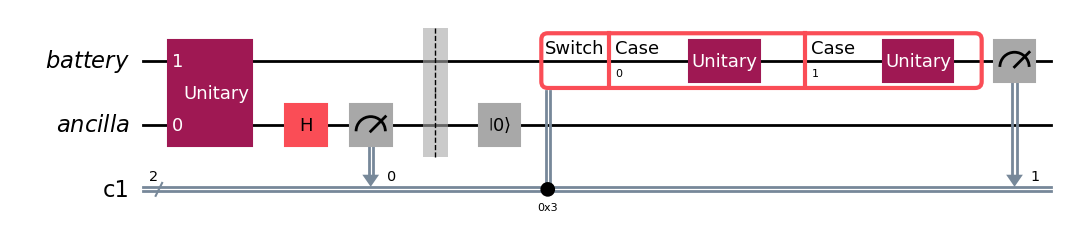

In [13]:
qc.draw(output= 'mpl')